# PINN for Burger's Equation
Resources:
https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
https://www.mathworks.com/help/deeplearning/ug/solve-partial-differential-equations-using-deep-learning.html
https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=pQhmdtsqZEkj

In [74]:
import numpy as np
import torch

boundary_points = 25 # actually 2*boundary_points, so 50
# boundary conditions
x_b = np.ones(2*boundary_points)
x_b[:boundary_points] = -1*x_b[:boundary_points]
t_b = np.linspace(0, 1, boundary_points)
t_b = np.concatenate((t_b, t_b))
u_b = np.zeros(2*boundary_points)

# inital conditions (t=0) 
initial_points = 50 # initial conditions
t_0 = np.zeros(initial_points)
x_0 = np.linspace(-1, 1, initial_points)
u_0 = -np.sin(x_0*np.pi)

# combine
t_c = np.concatenate((t_b, t_0))
x_c = np.concatenate((x_b, x_0))
u_c = np.concatenate((u_b, u_0))

# collocation points
num = 100
t = np.linspace(0, 1, num)
x = np.linspace(-1, 1, num)
t, x = np.meshgrid(t, x)
t = t.flatten()
x = x.flatten()

# convert to tensor
t = torch.tensor(t, dtype=torch.float)
x = torch.tensor(x, dtype=torch.float)

t_c = torch.tensor(t_c, dtype=torch.float)
x_c = torch.tensor(x_c, dtype=torch.float)
u_c = torch.tensor(u_c, dtype=torch.float)

In [95]:
t_c

tensor([0.0000, 0.0417, 0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333,
        0.3750, 0.4167, 0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083,
        0.7500, 0.7917, 0.8333, 0.8750, 0.9167, 0.9583, 1.0000, 0.0000, 0.0417,
        0.0833, 0.1250, 0.1667, 0.2083, 0.2500, 0.2917, 0.3333, 0.3750, 0.4167,
        0.4583, 0.5000, 0.5417, 0.5833, 0.6250, 0.6667, 0.7083, 0.7500, 0.7917,
        0.8333, 0.8750, 0.9167, 0.9583, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], requires_grad=True)

In [94]:
x_c

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000, -1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959,
        -0.7551, -0.7143, -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694,
        -0.4286, -0.3878, -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429,
        -0.1020, -0.0612, -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,
         0.2245,  0.2653,  0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,
         0.5510,  0.5918,  0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,
         0.8776,  0.9184,  0.9592,  1.00

In [97]:
t

tensor([0.0000, 0.0101, 0.0202,  ..., 0.9798, 0.9899, 1.0000],
       requires_grad=True)

In [5]:
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

class NeuralNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(NeuralNet, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.model = nn.Sequential(OrderedDict([
                                  ('linear1', nn.Linear(in_size, 50)),
                                  ('tanh1', nn.Tanh()),
                                  ('linear2', nn.Linear(50, 100)),
                                  ('tanh2', nn.Tanh()),
                                  ('linear3', nn.Linear(100, 200)),
                                  ('tanh3', nn.Tanh()),
                                  ('linear4', nn.Linear(200, out_size)),
                                  ('tanh4', nn.Tanh()),            
                                ]))
    def forward(self, t, x):
        inp = torch.stack([t, x], dim=1)
        return self.model(inp)

In [156]:
model = NeuralNet(2, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [157]:
viscosity = 0.01/np.pi

epochs=15

model.train(True)
losses = []
t.requires_grad_(True)
x.requires_grad_(True)
t_c.requires_grad_(True)
x_c.requires_grad_(True)
for i in range(epochs):
    # physics based loss
    u = model(t, x)
    dt  = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0] # computes du/dt
    dx  = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0] # computes du/dx
    dx2 = torch.autograd.grad(dx, x, torch.ones_like(dx),  create_graph=True)[0] # computes d^2u/dx^2
    loss_p = torch.mean((dt + u*dx - viscosity*dx2)**2)
    
    # conditions loss
    u = model(t_c, x_c)
    loss_c = torch.mean((u_c - u)**2) # MSE
    
    loss = loss_p + loss_c
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print("Loss:", loss.item())
    losses.append(loss.item())

KeyboardInterrupt: 

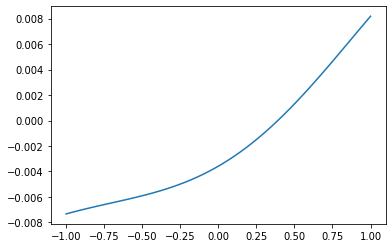

In [141]:
import matplotlib.pyplot as plt
time = 0
u_0_pred = model(torch.tensor(np.full((initial_points), time), dtype=torch.float), torch.tensor(x_0, dtype=torch.float))
plt.plot(x_0, u_0_pred.detach().numpy())

In [38]:
loss

tensor(12450., grad_fn=<AddBackward0>)

In [145]:
torch.mean((dt + u*dx - viscosity*dx2)**2)

tensor(0.0002, grad_fn=<MeanBackward0>)

In [ ]:
x.grad

In [158]:
model.model.linear1.bias

Parameter containing:
tensor([ 0.6277, -0.0271, -0.0325, -0.0997, -0.3802,  0.6260,  0.4715, -0.0189,
         0.0874,  0.1874, -0.4957,  0.6627, -0.3553, -0.0797,  0.0867, -0.5976,
        -0.1181, -0.5145,  0.5604, -0.4938,  0.5963, -0.6844,  0.2418, -0.6878,
         0.6167, -0.0112, -0.3064, -0.2450, -0.0576, -0.0939, -0.5764,  0.1771,
         0.2149,  0.0918,  0.5874, -0.0998,  0.0554, -0.7012,  0.0877,  0.1090,
        -0.6394,  0.5176,  0.2665,  0.2447, -0.3262, -0.6726,  0.0898,  0.2205,
        -0.6032, -0.6764], requires_grad=True)